# Import Modules

In [1]:
import sys
print("Python Version:", sys.version)

Python Version: 3.7.4 (default, Nov 22 2019, 21:31:39) 
[GCC 7.3.0]


In [2]:
# from __future__ import print_function, division

from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import psycopg2 as pg
import requests
import io
import math
import datetime
import csv

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statistics as stats
from statsmodels.tools import add_constant

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, RidgeCV
from sklearn import metrics
from sklearn.metrics import roc_curve, f1_score, accuracy_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, cross_val_score, cross_validate, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Display data tools
from IPython.display import display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import data from psql

In [3]:
connection_args = {
    'host': '3.18.213.250',  # You will need to put the PUBLIC IP address of your AWS instance here
    'user': 'ubuntu',    # your username on AWS is 'ubuntu'
    'dbname': 'restaurants',    # DB that we are connecting to
    'port': 5432             # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [4]:
inspections_df = pd.read_sql_query('SELECT "aka", "lic_no", "facility_type", "risk",\
"inspection_date", "inspection_type", "results", "zip", "city" FROM inspections;', connection)
inspections_df.head()

,aka,lic_no,facility_type,risk,inspection_date,inspection_type,results,zip,city
0,LONG TUNG CHINESE KITCHEN,1985572,Restaurant,Risk 1 (High),08/08/2016,Complaint,Pass w/ Conditions,60621,CHICAGO
1,MAGO GRILL & CANTINA,2423995,Restaurant,Risk 1 (High),06/17/2016,License Re-Inspection,Pass,60605,CHICAGO
2,THE RENAISSANCE AT SOUTH SHORE,2219946,Long Term Care,Risk 1 (High),10/18/2016,Canvass,Out of Business,60649,CHICAGO
3,Peace & Ed. Coalition Second Chance High School,67021,School,Risk 2 (Medium),09/19/2016,Canvass,Pass,60609,CHICAGO
4,CHICAGO EXCEL ACADEMY OF ENGLEWOOD,2845655,School,Risk 2 (Medium),10/13/2015,Canvass,Pass,60621,CHICAGO


# Make Dataframe workable

In [5]:
inspections_df.describe()

,aka,lic_no,facility_type,risk,inspection_date,inspection_type,results,zip,city
count,197864,200329,195568,200278,200346,200345,200346,200297,200203
unique,26486,37721,500,8,2560,121,13,114,76
top,SUBWAY,0,Restaurant,Risk 1 (High),11/14/2013,Canvass,Pass,60614,CHICAGO
freq,3335,523,133790,143839,185,106504,107025,7470,199477


In [6]:
inspections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200346 entries, 0 to 200345
Data columns (total 9 columns):
aka                197864 non-null object
lic_no             200329 non-null object
facility_type      195568 non-null object
risk               200278 non-null object
inspection_date    200346 non-null object
inspection_type    200345 non-null object
results            200346 non-null object
zip                200297 non-null object
city               200203 non-null object
dtypes: object(9)
memory usage: 13.8+ MB


In [7]:
inspections_df.shape

(200346, 9)

In [8]:
# Which columns have the most values in descending order?
inspections_df.apply(lambda x: x.count(), axis=0).sort_values(ascending=False)

results            200346
inspection_date    200346
inspection_type    200345
lic_no             200329
zip                200297
risk               200278
city               200203
aka                197864
facility_type      195568
dtype: int64

#### Get unique values for facility_type


In [9]:
inspections_df.facility_type.unique()

array(['Restaurant', 'Long Term Care', 'School', 'TAVERN', 'Hospital',
       'Mobile Food Preparer', 'Mobile Frozen Desserts Vendor',
       'CHURCH/SPECIAL EVENT', 'Shared Kitchen User (Long Term)',
       'Mobile Food Dispenser', 'Mobile Prepared Food Vendor', 'PUSHCART',
       'Daycare Combo 1586', 'Grocery Store', None, 'Golden Diner',
       'BREWERY', 'MFD TRUCK', 'Shared Kitchen User (Short Term)',
       'Daycare Above and Under 2 Years', 'Food Vending Machines',
       "Children's Services Facility", 'Catering', 'Special Event',
       'Daycare (Under 2 Years)', 'Daycare (2 - 6 Years)', 'Liquor',
       'Bakery', 'LIVE POULTRY', 'Daycare (2 Years)',
       'RESTAURANT/GAS STATION', 'GAS STATION/RESTAURANT', 'TEA BREWING',
       'VENDING MACHINE', 'Navy Pier Kiosk', 'Banquet Hall',
       'MOBILE DESSERTS VENDOR', 'HOTEL', 'SUPPORTIVE LIVING FACILITY',
       'RESTAURANT/BAR', 'Grocery(Sushi prep)', 'CAFETERIA',
       'HEALTH CARE STORE', 'WRIGLEY ROOFTOP', 'MOBILE FOOD',
 

#### Just keep 'Restaurant' 'facility_type'

In [10]:
restaurant_inspecs = inspections_df.loc[(inspections_df['facility_type'] == 'Restaurant')]

In [11]:
restaurant_inspecs = restaurant_inspecs.drop(columns=['city'])

### Make lic_no binary (0 = no license; 1 = yes license)


In [12]:
restaurant_inspecs['lic_no'] = restaurant_inspecs['lic_no'].apply(lambda x: 0 if (x =='None') else 1)

In [13]:
restaurant_inspecs['risk'] = restaurant_inspecs['risk'].replace({'Risk 1 (High)': 3, 'Risk 2 (Medium)': 2, 'Risk 3 (Low)': 1})

In [14]:
restaurant_inspecs.head()

,aka,lic_no,facility_type,risk,inspection_date,inspection_type,results,zip
0,LONG TUNG CHINESE KITCHEN,1,Restaurant,3,08/08/2016,Complaint,Pass w/ Conditions,60621
1,MAGO GRILL & CANTINA,1,Restaurant,3,06/17/2016,License Re-Inspection,Pass,60605
5,MAGO GRILL & CANTINA,1,Restaurant,3,06/17/2016,License Re-Inspection,Pass,60605
6,GASLIGHT CLUB (HILTON O'HARE LOBBY),1,Restaurant,3,07/13/2016,Canvass,Fail,60666
7,Porkchop,1,Restaurant,3,06/28/2016,Canvass,Pass,60605


### Convert inspection_date to year, month, and day of week

In [15]:
restaurant_inspecs['year'] = pd.to_datetime(restaurant_inspecs.inspection_date).dt.year

In [16]:
restaurant_inspecs['month'] = pd.to_datetime(restaurant_inspecs.inspection_date).dt.month

In [17]:
restaurant_inspecs['day'] = pd.to_datetime(restaurant_inspecs.inspection_date).dt.dayofweek

#### Make dummies for month

In [18]:
restaurant_inspecs = pd.get_dummies(restaurant_inspecs,columns=['month'])
restaurant_inspecs.head()

,aka,lic_no,facility_type,risk,inspection_date,inspection_type,results,zip,year,day,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,LONG TUNG CHINESE KITCHEN,1,Restaurant,3,08/08/2016,Complaint,Pass w/ Conditions,60621,2016,0,0,0,0,0,0,0,0,1,0,0,0,0
1,MAGO GRILL & CANTINA,1,Restaurant,3,06/17/2016,License Re-Inspection,Pass,60605,2016,4,0,0,0,0,0,1,0,0,0,0,0,0
5,MAGO GRILL & CANTINA,1,Restaurant,3,06/17/2016,License Re-Inspection,Pass,60605,2016,4,0,0,0,0,0,1,0,0,0,0,0,0
6,GASLIGHT CLUB (HILTON O'HARE LOBBY),1,Restaurant,3,07/13/2016,Canvass,Fail,60666,2016,2,0,0,0,0,0,0,1,0,0,0,0,0
7,Porkchop,1,Restaurant,3,06/28/2016,Canvass,Pass,60605,2016,1,0,0,0,0,0,1,0,0,0,0,0,0


#### Make dummies for day

In [19]:
restaurant_inspecs = pd.get_dummies(restaurant_inspecs,columns=['day'])
restaurant_inspecs.head()

,aka,lic_no,facility_type,risk,inspection_date,inspection_type,results,zip,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,LONG TUNG CHINESE KITCHEN,1,Restaurant,3,08/08/2016,Complaint,Pass w/ Conditions,60621,2016,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,MAGO GRILL & CANTINA,1,Restaurant,3,06/17/2016,License Re-Inspection,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,MAGO GRILL & CANTINA,1,Restaurant,3,06/17/2016,License Re-Inspection,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6,GASLIGHT CLUB (HILTON O'HARE LOBBY),1,Restaurant,3,07/13/2016,Canvass,Fail,60666,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
7,Porkchop,1,Restaurant,3,06/28/2016,Canvass,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


### Drop inspecion_date


In [20]:
restaurant_inspecs = restaurant_inspecs.drop("inspection_date", axis=1)

In [21]:
restaurant_inspecs.head()

,aka,lic_no,facility_type,risk,inspection_type,results,zip,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,LONG TUNG CHINESE KITCHEN,1,Restaurant,3,Complaint,Pass w/ Conditions,60621,2016,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,MAGO GRILL & CANTINA,1,Restaurant,3,License Re-Inspection,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,MAGO GRILL & CANTINA,1,Restaurant,3,License Re-Inspection,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6,GASLIGHT CLUB (HILTON O'HARE LOBBY),1,Restaurant,3,Canvass,Fail,60666,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
7,Porkchop,1,Restaurant,3,Canvass,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


### Deal with 'risk' column

In [22]:
restaurant_inspecs['risk'].value_counts()

3      107385
2       25028
1        1366
All         8
Name: risk, dtype: int64

#### Drop 'All' in risk column


In [23]:
rfc_test_df = restaurant_inspecs[restaurant_inspecs.risk != 'All']
rfc_test_df.head()

,aka,lic_no,facility_type,risk,inspection_type,results,zip,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,LONG TUNG CHINESE KITCHEN,1,Restaurant,3,Complaint,Pass w/ Conditions,60621,2016,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,MAGO GRILL & CANTINA,1,Restaurant,3,License Re-Inspection,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,MAGO GRILL & CANTINA,1,Restaurant,3,License Re-Inspection,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6,GASLIGHT CLUB (HILTON O'HARE LOBBY),1,Restaurant,3,Canvass,Fail,60666,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
7,Porkchop,1,Restaurant,3,Canvass,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


### Drop 'facility_type' column

In [24]:
rfc_test_df = rfc_test_df.drop(columns=['facility_type'])

In [25]:
rfc_test_df.head()

,aka,lic_no,risk,inspection_type,results,zip,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,LONG TUNG CHINESE KITCHEN,1,3,Complaint,Pass w/ Conditions,60621,2016,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,MAGO GRILL & CANTINA,1,3,License Re-Inspection,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,MAGO GRILL & CANTINA,1,3,License Re-Inspection,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6,GASLIGHT CLUB (HILTON O'HARE LOBBY),1,3,Canvass,Fail,60666,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
7,Porkchop,1,3,Canvass,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


### Deal with 'results' column

Referenced from here: [City of Chicago - Dataset_Description_FoodInspections](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)

Results: An inspection can *pass*, *pass with conditions*, or *fail*

- I'm going to change *'Pass w/ Conditions'* to *'Pass'*, because establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. 

I then want to get rid of the other results that do not apply, e.g. 'Out of Business', 'No Entry', 'Not Ready', 'Business Not Located'

#### Replace 'Pass w/ Conditions' with 'Pass' in results column


In [26]:
rfc_test_df_2 = rfc_test_df.replace({'Pass w/ Conditions':'Pass'})

#### Get new df for just results = Pass or Fail


In [27]:
rfc_test_df_3 = rfc_test_df_2.loc[(rfc_test_df_2['results'] == 'Pass') | \
                                      (rfc_test_df_2['results'] == 'Fail')]

### Deal with 'inspection_type' column

**inspection_type descriptions:**

1. canvass: 
    - The most common type of inspection performed at a frequency relative to the risk of the establishment 

2. Consultation:
    - When the inspection is done at the request of the owner prior to the opening of the establishment 

3. Complaint: 
    - When the inspection is done in response to a complaint against the establishment:
        - I broke this up into 2 separate types:
            - 3A ComplaintBased_Other
            - 3B. ComplaintBased_Food:
                - Suspected food poisoning, when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint- based inspection)

4. License:
    - When the inspection is done as a requirement for the establishment to receive its license to operate

5. Task Force:
    - When an inspection of a bar or tavern is done

Adding 3 more:

7. Out of Business

8. No_Entry

9. Other_or_None

##### Replace 'inspection_type' appropriately  

In [28]:
rfc_test_df_3['inspection_type'] = rfc_test_df_3['inspection_type'].\
replace(['CANVASS SPECIAL EVENTS','CANVAS','CANVASS FOR RIB FEST','Canvass Re-Inspection', 'CANVASS RE INSPECTION OF CLOSE UP','Canvass'],'canvass')
rfc_test_df_3['inspection_type'] = rfc_test_df_3['inspection_type'].\
replace(['SFP/Complaint','SFP','SFP/COMPLAINT','TWO PEOPLE ATE AND GOT SICK.','SFP RECENTLY INSPECTED','Suspected Food Poisoning Re-inspection','Suspected Food Poisoning'],'Complaint_Food') 
rfc_test_df_3['inspection_type'] = rfc_test_df_3['inspection_type'].\
replace(['Complaint','Short Form Fire-Complaint','Complaint-Fire','Short Form Complaint','Complaint Re-Inspection','NO ENTRY-SHORT COMPLAINT)','finish complaint inspection from 5-18-10','Complaint-Fire Re-inspection','fire complaint','FIRE/COMPLAIN'],'Complaint_Other')
rfc_test_df_3['inspection_type'] = rfc_test_df_3['inspection_type'].\
replace(['LICENSE REQUEST','1315 license reinspection','License Re-Inspection'],'License')
rfc_test_df_3['inspection_type'] = rfc_test_df_3['inspection_type'].\
replace(['Out of Business','OUT OF BUSINESS'],'Out_of_Business')
rfc_test_df_3['inspection_type'] = rfc_test_df_3['inspection_type'].\
replace('Pre-License Consultation','Consultation')
rfc_test_df_3['inspection_type'] = rfc_test_df_3['inspection_type'].\
replace(['no entry','No entry','NO ENTRY','No Entry'],'No_Entry')
rfc_test_df_3['inspection_type'] = rfc_test_df_3['inspection_type'].\
replace(['Tag Removal','Special Events (Festivals)','Package Liquor 1474','Recent inspection','CHANGED COURT DATE','TASTE OF CHICAGO','citation re-issued','LIQUOR CATERING','LICENSE/NOT READY','POSSIBLE FBI','Not Ready','REINSPECTION',None,'HACCP QUESTIONAIRE','expansion','Non-Inspection','RE-INSPECTION OF CLOSE-UP','error save'],'Other_or_None')
rfc_test_df_3['inspection_type'] = rfc_test_df_3['inspection_type'].\
replace(['Task Force Liquor 1475','Recent Inspection','License-Task Force','LICENSE TASK FORCE / NOT -FOR-PROFIT CLUB','LICENSE TASK FORCE / NOT -FOR-PROFIT CLU','Task Force Liquor Catering','TASK FORCE NOT READY', 'TASKFORCE','TASK FORCE LIQUOR (1481)','LIQOUR TASK FORCE NOT READY'],'Task_Force')

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [29]:
rfc_test_df_3['inspection_type'].value_counts(ascending=True)

CORRECTIVE ACTION        1
Sample Collection        1
Out_of_Business         55
No_Entry                56
Consultation           394
Other_or_None          534
Task_Force             733
Complaint_Food         921
License              18101
Complaint_Other      24531
canvass              72433
Name: inspection_type, dtype: int64

#### Get rid of Sample Collection and CORRECTIVE ACTION rows


In [30]:
rfc_test_df_4 = rfc_test_df_3[rfc_test_df_3.inspection_type != 'Sample Collection']

In [31]:
rfc_test_df_5 = rfc_test_df_4[rfc_test_df_4.inspection_type != 'CORRECTIVE ACTION']

In [32]:
rfc_test_df_5['inspection_type'].value_counts(ascending=True)

Out_of_Business       55
No_Entry              56
Consultation         394
Other_or_None        534
Task_Force           733
Complaint_Food       921
License            18101
Complaint_Other    24531
canvass            72433
Name: inspection_type, dtype: int64

### New df for dummies 'inspection_type' column


In [33]:
# don't drop_first
rfc_test_df_6 = pd.get_dummies(rfc_test_df_5,columns=['inspection_type'])
rfc_test_df_6.head()

,aka,lic_no,risk,results,zip,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6,inspection_type_Complaint_Food,inspection_type_Complaint_Other,inspection_type_Consultation,inspection_type_License,inspection_type_No_Entry,inspection_type_Other_or_None,inspection_type_Out_of_Business,inspection_type_Task_Force,inspection_type_canvass
0,LONG TUNG CHINESE KITCHEN,1,3.0,Pass,60621,2016,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,MAGO GRILL & CANTINA,1,3.0,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
5,MAGO GRILL & CANTINA,1,3.0,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
6,GASLIGHT CLUB (HILTON O'HARE LOBBY),1,3.0,Fail,60666,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
7,Porkchop,1,3.0,Pass,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### New df for dummies 'results' column

In [34]:
rfc_test_df_7 = pd.get_dummies(rfc_test_df_6,columns=['results'],drop_first=True)
rfc_test_df_7.head()

,aka,lic_no,risk,zip,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6,inspection_type_Complaint_Food,inspection_type_Complaint_Other,inspection_type_Consultation,inspection_type_License,inspection_type_No_Entry,inspection_type_Other_or_None,inspection_type_Out_of_Business,inspection_type_Task_Force,inspection_type_canvass,results_Pass
0,LONG TUNG CHINESE KITCHEN,1,3.0,60621,2016,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,MAGO GRILL & CANTINA,1,3.0,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
5,MAGO GRILL & CANTINA,1,3.0,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
6,GASLIGHT CLUB (HILTON O'HARE LOBBY),1,3.0,60666,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,Porkchop,1,3.0,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


### Deal with NANs

#### Which rows have NaN?


In [35]:
rfc_test_df_7[rfc_test_df_7.isna().any(axis=1)]

,aka,lic_no,risk,zip,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6,inspection_type_Complaint_Food,inspection_type_Complaint_Other,inspection_type_Consultation,inspection_type_License,inspection_type_No_Entry,inspection_type_Other_or_None,inspection_type_Out_of_Business,inspection_type_Task_Force,inspection_type_canvass,results_Pass
41,None,1,3.0,60625,2010,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
338,CASA CENTRAL LA POSADA,1,3.0,None,2010,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
823,None,1,3.0,60620,2013,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
854,None,1,2.0,60623,2012,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1021,None,1,3.0,60611,2013,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199252,None,1,3.0,60657,2010,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
199607,None,1,3.0,60607,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
200023,None,1,2.0,60619,2014,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
200126,None,1,1.0,60611,2016,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [36]:
# Looks like some restaurants don't have a name
# This won't be very helpful for predictions, so we can drop them
rfc_test_df_8 = rfc_test_df_7.dropna()
rfc_test_df_8.head()

,aka,lic_no,risk,zip,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6,inspection_type_Complaint_Food,inspection_type_Complaint_Other,inspection_type_Consultation,inspection_type_License,inspection_type_No_Entry,inspection_type_Other_or_None,inspection_type_Out_of_Business,inspection_type_Task_Force,inspection_type_canvass,results_Pass
0,LONG TUNG CHINESE KITCHEN,1,3.0,60621,2016,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,MAGO GRILL & CANTINA,1,3.0,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
5,MAGO GRILL & CANTINA,1,3.0,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
6,GASLIGHT CLUB (HILTON O'HARE LOBBY),1,3.0,60666,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,Porkchop,1,3.0,60605,2016,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


### Rename 'results_Pass' column to 'Results_Pass_Fail' 

In [37]:
rfc_test_df_8 = rfc_test_df_8.rename(columns={"results_Pass": "Results_Pass_Fail"})

### Make sure datatypes look good

In [38]:
rfc_test_df_8.dtypes

aka                                 object
lic_no                               int64
risk                               float64
zip                                 object
year                                 int64
month_1                              uint8
month_2                              uint8
month_3                              uint8
month_4                              uint8
month_5                              uint8
month_6                              uint8
month_7                              uint8
month_8                              uint8
month_9                              uint8
month_10                             uint8
month_11                             uint8
month_12                             uint8
day_0                                uint8
day_1                                uint8
day_2                                uint8
day_3                                uint8
day_4                                uint8
day_5                                uint8
day_6      

#### Change risk type to int from float


In [39]:
rfc_test_df_8['risk'] = rfc_test_df_8['risk'].astype(int)

#### Change 'zip' to int from object


In [40]:
rfc_test_df_8['zip'] = rfc_test_df_8['zip'].astype(int)

In [41]:
rfc_test_df_8.dtypes

aka                                object
lic_no                              int64
risk                                int64
zip                                 int64
year                                int64
month_1                             uint8
month_2                             uint8
month_3                             uint8
month_4                             uint8
month_5                             uint8
month_6                             uint8
month_7                             uint8
month_8                             uint8
month_9                             uint8
month_10                            uint8
month_11                            uint8
month_12                            uint8
day_0                               uint8
day_1                               uint8
day_2                               uint8
day_3                               uint8
day_4                               uint8
day_5                               uint8
day_6                             

### Combine Income & Zip df on 'zip' column 

#### Read in pickled data

In [42]:
unpickled_df = pd.read_pickle("./inc_zip_df.pkl")
unpickled_df.head()

,zip,population,income
1,60606,1682,100377.0
2,60601,5591,77374.0
3,60611,26522,69889.0
4,60614,65474,68324.0
5,60603,378,61815.0


### Join the dataframes on 'zip' column

In [43]:
unpickled_df.dtypes

zip             int64
population      int64
income        float64
dtype: object

In [44]:
zip_combined_df = pd.merge(unpickled_df, rfc_test_df_8, on='zip')

In [45]:
zip_combined_df

,zip,population,income,aka,lic_no,risk,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6,inspection_type_Complaint_Food,inspection_type_Complaint_Other,inspection_type_Consultation,inspection_type_License,inspection_type_No_Entry,inspection_type_Other_or_None,inspection_type_Out_of_Business,inspection_type_Task_Force,inspection_type_canvass,Results_Pass_Fail
0,60606,1682,100377.0,STARBUCKS COFFEE,1,2,2016,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1,60606,1682,100377.0,KELLY'S CAJUN GRILL,1,3,2014,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
2,60606,1682,100377.0,MONK'S PUB,1,3,2013,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,60606,1682,100377.0,GIORDANO'S ON JACKSON,1,3,2011,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
4,60606,1682,100377.0,Skadden Cafe,1,3,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108961,60653,34502,14205.0,CHICAGO'S HOME OF CHICKEN & WAFFLES,1,3,2017,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
108962,60653,34502,14205.0,SIP & SAVOR,1,2,2018,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
108963,60653,34502,14205.0,MCDONALDS,1,2,2018,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
108964,60653,34502,14205.0,CHICAGO'S HOME OF CHICKEN & WAFFLES,1,3,2019,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


### Dummy out 'zip' column

In [46]:
zip_combined_df_2 = pd.get_dummies(zip_combined_df,columns=['zip'])
zip_combined_df_2.head()

,population,income,aka,lic_no,risk,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6,inspection_type_Complaint_Food,inspection_type_Complaint_Other,inspection_type_Consultation,inspection_type_License,inspection_type_No_Entry,inspection_type_Other_or_None,inspection_type_Out_of_Business,inspection_type_Task_Force,inspection_type_canvass,Results_Pass_Fail,zip_60601,zip_60602,zip_60603,zip_60604,zip_60605,zip_60606,zip_60607,zip_60608,zip_60609,zip_60610,zip_60611,zip_60612,zip_60613,zip_60614,zip_60615,zip_60616,zip_60617,zip_60618,zip_60619,zip_60620,zip_60621,zip_60622,zip_60623,zip_60624,zip_60625,zip_60626,zip_60628,zip_60629,zip_60630,zip_60631,zip_60632,zip_60633,zip_60634,zip_60636,zip_60637,zip_60638,zip_60639,zip_60640,zip_60641,zip_60643,zip_60644,zip_60645,zip_60646,zip_60647,zip_60649,zip_60651,zip_60652,zip_60653,zip_60655,zip_60656,zip_60657,zip_60659,zip_60660,zip_60661
0,1682,100377.0,STARBUCKS COFFEE,1,2,2016,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1682,100377.0,KELLY'S CAJUN GRILL,1,3,2014,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1682,100377.0,MONK'S PUB,1,3,2013,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1682,100377.0,GIORDANO'S ON JACKSON,1,3,2011,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1682,100377.0,Skadden Cafe,1,3,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Dummy out 'year' column

In [47]:
zip_combined_df_3 = pd.get_dummies(zip_combined_df_2,columns=['year'])
zip_combined_df_3.head()

,population,income,aka,lic_no,risk,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_0,day_1,day_2,day_3,day_4,day_5,day_6,inspection_type_Complaint_Food,inspection_type_Complaint_Other,inspection_type_Consultation,inspection_type_License,inspection_type_No_Entry,inspection_type_Other_or_None,inspection_type_Out_of_Business,inspection_type_Task_Force,inspection_type_canvass,Results_Pass_Fail,zip_60601,zip_60602,zip_60603,zip_60604,zip_60605,zip_60606,zip_60607,zip_60608,zip_60609,zip_60610,zip_60611,zip_60612,zip_60613,zip_60614,zip_60615,zip_60616,zip_60617,zip_60618,zip_60619,zip_60620,zip_60621,zip_60622,zip_60623,zip_60624,zip_60625,zip_60626,zip_60628,zip_60629,zip_60630,zip_60631,zip_60632,zip_60633,zip_60634,zip_60636,zip_60637,zip_60638,zip_60639,zip_60640,zip_60641,zip_60643,zip_60644,zip_60645,zip_60646,zip_60647,zip_60649,zip_60651,zip_60652,zip_60653,zip_60655,zip_60656,zip_60657,zip_60659,zip_60660,zip_60661,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
0,1682,100377.0,STARBUCKS COFFEE,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1682,100377.0,KELLY'S CAJUN GRILL,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1682,100377.0,MONK'S PUB,1,3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1682,100377.0,GIORDANO'S ON JACKSON,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1682,100377.0,Skadden Cafe,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [48]:
zip_combined_df_3.shape

(108966, 99)

## Modeling

### Look at most important features:

In [49]:
y = zip_combined_df_3['Results_Pass_Fail']
X = zip_combined_df_3.drop(columns = ['Results_Pass_Fail', 'aka'])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

#### List by DTC feature importance with column

In [51]:
X.shape

(108966, 97)

In [52]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [53]:
dtc_imp_list = list(zip(dtc.feature_importances_, X.columns))

#### DTC sort list by first column descending

In [54]:
sorted(dtc_imp_list, reverse=True)

[(0.06779111500751983, 'population'),
 (0.06627643668526788, 'income'),
 (0.046975678569641625, 'day_1'),
 (0.04554245661999605, 'day_3'),
 (0.039903557453467575, 'day_4'),
 (0.03682137463446203, 'day_2'),
 (0.03500010860145224, 'day_0'),
 (0.031070966417796598, 'risk'),
 (0.02668663457983504, 'month_10'),
 (0.02649467038003169, 'month_7'),
 (0.02606190971890375, 'month_6'),
 (0.025896347374105642, 'month_2'),
 (0.02544047994540253, 'month_4'),
 (0.025135606226304848, 'month_8'),
 (0.024976442942248392, 'month_3'),
 (0.02480229877923375, 'month_5'),
 (0.023244638700587187, 'month_1'),
 (0.022276890926744633, 'month_11'),
 (0.020922240069015104, 'month_12'),
 (0.01949760860648666, 'month_9'),
 (0.01814665718187505, 'year_2018'),
 (0.01804551449150646, 'year_2010'),
 (0.01683315819306799, 'year_2014'),
 (0.016399567030500363, 'inspection_type_canvass'),
 (0.016124771093997042, 'year_2013'),
 (0.015987250885649822, 'year_2012'),
 (0.015639072648137298, 'year_2017'),
 (0.01531464390148285,

#### List by RFC feature importance with column


In [55]:
y = zip_combined_df_3['Results_Pass_Fail']
X = zip_combined_df_3.drop(columns = ['Results_Pass_Fail', 'aka'])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [57]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
rfc_imp_list = list(zip(rfc.feature_importances_,X.columns))

#### RFC sort list by first column descending

In [59]:
sorted(rfc_imp_list, reverse=True)

[(0.06065987226905615, 'income'),
 (0.059006304016078426, 'population'),
 (0.045300813479143394, 'risk'),
 (0.03945273902876805, 'day_3'),
 (0.03879751818046266, 'day_1'),
 (0.03589319992645854, 'day_4'),
 (0.03251932665939139, 'day_2'),
 (0.032235636296774985, 'day_0'),
 (0.027414133535116753, 'month_5'),
 (0.02632406062938907, 'month_6'),
 (0.025508513273641776, 'month_8'),
 (0.025168231351598243, 'month_10'),
 (0.02506674620921399, 'month_4'),
 (0.02469190199002809, 'month_1'),
 (0.02410006435412097, 'month_3'),
 (0.02406036202109988, 'month_2'),
 (0.02373101925598922, 'month_9'),
 (0.023686064319302653, 'month_11'),
 (0.02356151454343893, 'month_7'),
 (0.01976792353888135, 'year_2019'),
 (0.019193570932958794, 'year_2012'),
 (0.017528792597381555, 'year_2018'),
 (0.017299913309211195, 'year_2017'),
 (0.016660768941973266, 'year_2015'),
 (0.01658687904023041, 'month_12'),
 (0.016545447165030747, 'year_2016'),
 (0.014502410764830545, 'year_2010'),
 (0.014213970976163304, 'year_2013')

### Create new df based on top ~ 30 important features from RFC & DTC list

In [60]:
zip_combined_df_4 = zip_combined_df_3[['Results_Pass_Fail', 'aka',\
'population',\
'income',\
'risk',\
'day_1',\
'day_3',\
'day_2',\
'day_4',\
'day_0',\
'month_6',\
'month_3',\
'month_7',\
'month_2',\
'month_8',\
'month_11',\
'month_4',\
'month_5',\
'month_10',\
'year_2017',\
'year_2012',\
'month_1',\
'year_2015',\
'year_2016',\
'year_2011',\
'year_2019',\
'year_2018',\
'month_9',\
'year_2010',\
'month_12',\
'year_2013',\
'year_2014',\
'inspection_type_License',\
'inspection_type_canvass',\
'inspection_type_Complaint_Other']]

In [61]:
zip_combined_df_4.head()

,Results_Pass_Fail,aka,population,income,risk,day_1,day_3,day_2,day_4,day_0,month_6,month_3,month_7,month_2,month_8,month_11,month_4,month_5,month_10,year_2017,year_2012,month_1,year_2015,year_2016,year_2011,year_2019,year_2018,month_9,year_2010,month_12,year_2013,year_2014,inspection_type_License,inspection_type_canvass,inspection_type_Complaint_Other
0,1,STARBUCKS COFFEE,1682,100377.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,KELLY'S CAJUN GRILL,1682,100377.0,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,1,MONK'S PUB,1682,100377.0,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,1,GIORDANO'S ON JACKSON,1682,100377.0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,Skadden Cafe,1682,100377.0,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Run Models

In [62]:
y = zip_combined_df_4['Results_Pass_Fail']
X = zip_combined_df_4.drop(columns = ['Results_Pass_Fail', 'aka'])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

#### Print Logistic Regression, KNN, GNB, DTC, RFC accuracy

In [64]:
# Print accuracy Logistic Regression
log_reg4 = LogisticRegression(solver= 'liblinear')
log_reg4.fit(X_train, y_train)
log_reg_predict4 = log_reg4.predict(X_test)
log_reg_accuracy4 = accuracy_score(y_test, log_reg_predict4)
log_reg_accuracy4
# This run: 0.7866319975527685

0.7866319975527685

In [65]:
# Print accuracy KNN
knn4 = KNeighborsClassifier(n_neighbors=5)
knn4.fit(X_train, y_train)
knn_predict4 = knn4.predict(X_test)
knn_accuracy4 = accuracy_score(y_test, knn_predict4)
knn_accuracy4
# This run: 0.7478739675741817

0.7478739675741817

In [66]:
# Print accuracy GNB
gnb4 = GaussianNB()
gnb4.fit(X_train, y_train)
gnb_predict4 = gnb4.predict(X_test)
gnb_accuracy4 = accuracy_score(y_test, gnb_predict4)
gnb_accuracy4
# This run: 0.7866319975527685

0.7866319975527685

In [67]:
# Print accuracy DTC
dtc4 = DecisionTreeClassifier()
dtc4.fit(X_train, y_train)
dtc_predict4 = dtc4.predict(X_test)
dtc_accuracy4 = accuracy_score(y_test, dtc_predict4)
dtc_accuracy4
# This run: 0.673661670235546

0.67363107984093

In [68]:
# Using best params from GridSearch results
# Print accuracy RFC
rfc4 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\
                             max_depth=9, max_features='auto', max_leaf_nodes=None,\
                             min_impurity_decrease=0.0, min_impurity_split=None,\
                             min_samples_leaf=1, min_samples_split=2,\
                             min_weight_fraction_leaf=0.0, n_estimators=15,\
                             n_jobs=None, oob_score=False, random_state=None,\
                             verbose=0, warm_start=False)
rfc4.fit(X_train, y_train)
rfc_predict4 = rfc4.predict(X_test)
rfc_accuracy4 = accuracy_score(y_test, rfc_predict4)
rfc_accuracy4
# This run: 0.7866931783420006

0.7866319975527685

### ROC curve for models

AUC for LGR4 model is 0.5315714312595259
AUC for KNN4 model is 0.5565327434652105
AUC for GNB4 model is 0.5701632911630591
AUC for DTC4 model is 0.535182031881034
AUC for RFC4 model is 0.5979400416894034


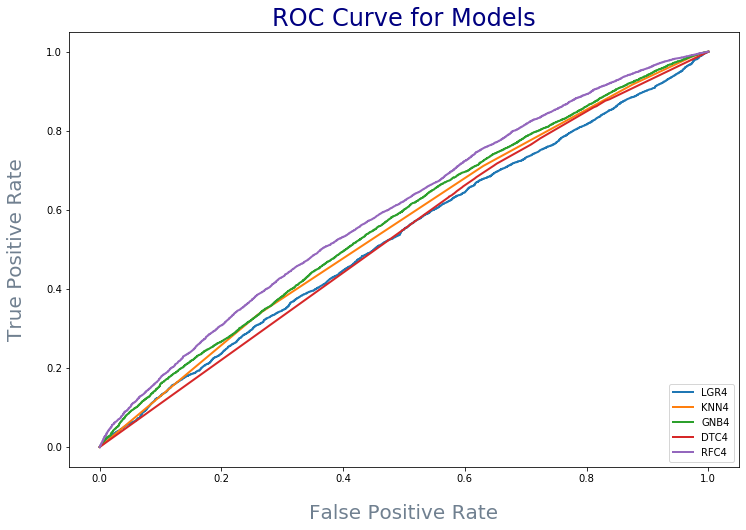

In [69]:
model_name = ['LGR4', 'KNN4', 'GNB4', 'DTC4','RFC4']
classifiers = [log_reg4, knn4, gnb4, dtc4, rfc4]

plt.figure(figsize=(12,8))

for r in range(len(model_name)):
    false_pos, true_pos, thresholds = roc_curve(y_test, classifiers[r].predict_proba(X_test)[:,1], pos_label=1)
    AUC_score = roc_auc_score(y_test, classifiers[r].predict_proba(X_test)[:,1])
    print(f'AUC for {model_name[r]} model is {AUC_score}')
    plt.plot(false_pos, true_pos, linewidth=2, label=model_name[r])
    plt.title('ROC Curve for Models', fontsize='24', color = 'navy')
    plt.xlabel('False Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.ylabel('True Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.legend(loc="lower right")

**Nothing stands out too much from the pack**

## Dealing with imbalanced classes

### Import resample module

In [70]:
from sklearn.utils import resample

In [71]:
zip_combined_df_4.Results_Pass_Fail.value_counts()

1    85698
0    23268
Name: Results_Pass_Fail, dtype: int64

### Separate majority and minority classes


In [72]:
zip_combined_majority = zip_combined_df_4[zip_combined_df_4.Results_Pass_Fail==1]
zip_combined_minority = zip_combined_df_4[zip_combined_df_4.Results_Pass_Fail==0]

### Upsample minority class


In [73]:
zip_combined_minority_upsampled = resample(zip_combined_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=85698,    # to match majority class
                                 random_state=123) # reproducible results

### Combine majority class with upsampled minority class


In [74]:
zip_combined_upsampled = pd.concat\
([zip_combined_majority, zip_combined_minority_upsampled])

### Display new class counts


In [75]:
zip_combined_upsampled.Results_Pass_Fail.value_counts()

1    85698
0    85698
Name: Results_Pass_Fail, dtype: int64

In [76]:
zip_combined_upsampled.shape

(171396, 35)

## Rerun model now that classes are balanced

In [77]:
y = zip_combined_upsampled['Results_Pass_Fail']
X = zip_combined_upsampled.drop(columns = ['Results_Pass_Fail', 'aka'])

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

### Update GridSearch values for RFC

In [79]:
clf2 = RandomForestClassifier(n_estimators=20) #Initialize with whatever parameters you want to

# 10-Fold Cross validation
print(np.mean(cross_val_score(clf2, X_train, y_train, cv=10)))

# This score: 0.7592038015575227

0.7574617681437312


In [80]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20],
                 'max_depth': [2, 5, 7, 9]
             }

In [81]:
# instantiate the grid
grid_clf2 = GridSearchCV(clf2, param_grid, cv=10, scoring='accuracy')

In [82]:
# fit the grid with data
# Should this be on the train data??
grid_clf2.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [83]:
# examine the best model
print(grid_clf2.best_score_)
print(grid_clf2.best_params_)
print(grid_clf2.best_estimator_)

0.5845870458504546
{'max_depth': 9, 'n_estimators': 20}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


### GridSearch values for DTC

In [84]:
y = zip_combined_upsampled['Results_Pass_Fail']
X = zip_combined_upsampled.drop(columns = ['Results_Pass_Fail', 'aka'])

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [86]:
from sklearn.ensemble import AdaBoostClassifier

In [87]:
from sklearn.metrics import make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [88]:
# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
grid_dtc2 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(2, 403, 10)},
                  scoring=scoring, refit='AUC', return_train_score=True)

In [89]:
# fit the grid with data
grid_dtc2.fit(X_train, y_train)

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(2, 403, 10)},
             pre_dispatch='2*n_jobs', refit='AUC', return_train_sco

In [90]:
# examine the best model
print(grid_dtc2.best_score_)
print(grid_dtc2.best_params_)
print(grid_dtc2.best_estimator_)

0.7558688332275241
{'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')


#### Print Logistic Regression, KNN, GNB, DTC, RFC accuracy again

In [91]:
y = zip_combined_upsampled['Results_Pass_Fail']
X = zip_combined_upsampled.drop(columns = ['Results_Pass_Fail', 'aka'])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [93]:
# Print accuracy Logistic Regression
log_reg5 = LogisticRegression(solver= 'liblinear')
log_reg5.fit(X_train, y_train)
log_reg_predict5 = log_reg5.predict(X_test)
log_reg_accuracy5 = accuracy_score(y_test, log_reg_predict5)
log_reg_accuracy5
# Last run: 0.7866319975527685
# This run: 0.5205079834302495

0.5205079834302495

In [94]:
# Print accuracy KNN
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
knn_predict5 = knn5.predict(X_test)
knn_accuracy5 = accuracy_score(y_test, knn_predict5)
knn_accuracy5
# Last run: 0.749678800856531
# This run: 0.6793792177988681

0.6793792177988681

In [95]:
# Print accuracy GNB
gnb5 = GaussianNB()
gnb5.fit(X_train, y_train)
gnb_predict5 = gnb5.predict(X_test)
gnb_accuracy5 = accuracy_score(y_test, gnb_predict5)
gnb_accuracy5
# Last run: 0.7866319975527685
# This run: 0.5341799723837491

0.5341799723837491

In [96]:
# Using best params from GridSearch results
# Print accuracy DTC
dtc5 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
dtc5.fit(X_train, y_train)
dtc_predict5 = dtc5.predict(X_test)
dtc_accuracy5 = accuracy_score(y_test, dtc_predict5)
dtc_accuracy5
# Last run: 0.6722239216885898
# This run: 0.758318909352574

0.758318909352574

In [97]:
# Using best params from GridSearch results
# Print accuracy RFC
rfc5 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc5.fit(X_train, y_train)
rfc_predict5 = rfc5.predict(X_test)
rfc_accuracy5 = accuracy_score(y_test, rfc_predict5)
rfc_accuracy5
# Last run: 0.7868155399204649
# This run: 0.5812442871312161

0.5812637351951613

AUC for LGR5 model is 0.5292945907706789
AUC for KNN5 model is 0.737273461488521
AUC for GNB5 model is 0.5626419544935178
AUC for DTC5 model is 0.797162707935465
AUC for RFC5 model is 0.6283185902362904
AUC for GRID_CLF2 model is 0.6304109711488339
AUC for GRID_DTC2 model is 0.797162707935465


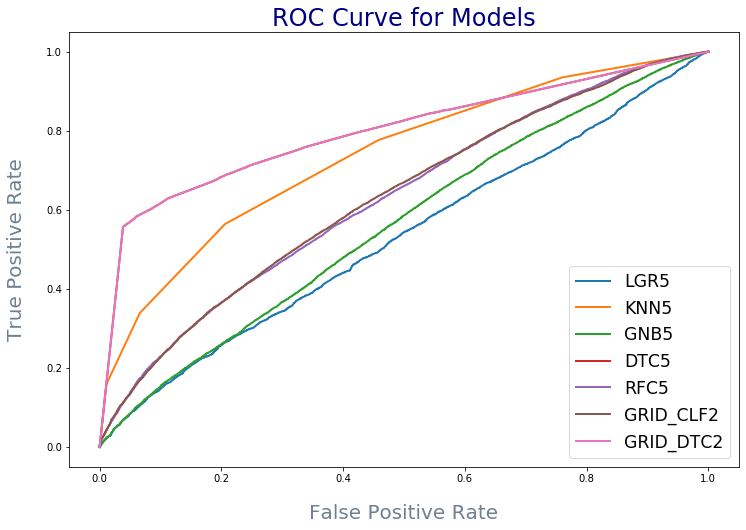

In [98]:
model_name = ['LGR5', 'KNN5', 'GNB5', 'DTC5','RFC5', 'GRID_CLF2', 'GRID_DTC2']
classifiers = [log_reg5, knn5, gnb5, dtc5, rfc5, grid_clf2, grid_dtc2]

plt.figure(figsize=(12,8))

for r in range(len(model_name)):
    false_pos, true_pos, thresholds = roc_curve(y_test, classifiers[r].predict_proba(X_test)[:,1], pos_label=1)
    AUC_score = roc_auc_score(y_test, classifiers[r].predict_proba(X_test)[:,1])
    print(f'AUC for {model_name[r]} model is {AUC_score}')
    plt.plot(false_pos, true_pos, linewidth=2, label=model_name[r])
    plt.title('ROC Curve for Models', fontsize='24', color = 'navy')
    plt.xlabel('False Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.ylabel('True Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.legend(loc="lower right", fontsize= 'xx-large')

In [99]:
grid_dtc2.best_score_

0.7558688332275241

### Slightly better restults - GRID_DTC2 is still best:
    - AUC for GRID_DTC2 model is 0.797162707935465
    - grid_dtc2.best_score_ = 0.7558688332275241

### Check to see if model is overfit or underfit

In [100]:
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!

stacked = StackingClassifier(
    classifiers=classifiers, meta_classifier=LogisticRegression(), use_probas=False)

In [101]:
stacked.fit(X_train, y_train)

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='liblinear',
                                                   tol=0.0001, verbose=0,
                                                   warm_start=False),
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                        

In [102]:
AUC_score_stacked = roc_auc_score(y_train, stacked.predict_proba(X_train)[:,1])
AUC_score_stacked

0.8941996116646156

In [103]:
AUC_score_stacked = roc_auc_score(y_test, stacked.predict_proba(X_test)[:,1])
AUC_score_stacked

0.7905400068877915

#### Is my model over fit or underfit?
This seems to indicate my model is pretty pretty good?

## Feature Engineering 

In [104]:
zip_combined_upsampled.groupby('Results_Pass_Fail').mean()

,population,income,risk,day_1,day_3,day_2,day_4,day_0,month_6,month_3,month_7,month_2,month_8,month_11,month_4,month_5,month_10,year_2017,year_2012,month_1,year_2015,year_2016,year_2011,year_2019,year_2018,month_9,year_2010,month_12,year_2013,year_2014,inspection_type_License,inspection_type_canvass,inspection_type_Complaint_Other
Results_Pass_Fail,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60198.383708,43508.241278,2.802481,0.235490,0.236505,0.169887,0.190903,0.166947,0.097272,0.084086,0.084156,0.071204,0.098170,0.070795,0.082172,0.089010,0.087668,0.118171,0.085708,0.080002,0.096957,0.119979,0.098614,0.099816,0.086431,0.096607,0.100971,0.058858,0.088824,0.099921,0.217706,0.521669,0.234638
1,57142.537224,45466.441469,2.796495,0.225641,0.231592,0.179316,0.204672,0.158510,0.094926,0.090586,0.078427,0.074401,0.091577,0.074167,0.085311,0.090831,0.084308,0.109851,0.085673,0.083888,0.105603,0.119816,0.090691,0.093258,0.085230,0.084564,0.087260,0.067014,0.102604,0.116514,0.133504,0.636608,0.208371


### Results:

*Failing* an inspection (0) is coincided with *higher* population
- population = 60198.383708 - 57142.537224 = 3055.846484


On the other hand, *passing* an inspection (1) is coincided with *higher* income
- income = 45466.441469 - 43508.241278 = 1958.200191


### Feature engineering with population column

In [105]:
zip_combined_upsampled.groupby('population').mean()

,Results_Pass_Fail,income,risk,day_1,day_3,day_2,day_4,day_0,month_6,month_3,month_7,month_2,month_8,month_11,month_4,month_5,month_10,year_2017,year_2012,month_1,year_2015,year_2016,year_2011,year_2019,year_2018,month_9,year_2010,month_12,year_2013,year_2014,inspection_type_License,inspection_type_canvass,inspection_type_Complaint_Other
population,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
70,0.599276,23750.0,2.812915,0.236572,0.232348,0.147858,0.199759,0.182861,0.101388,0.078455,0.077852,0.072420,0.101388,0.103199,0.063971,0.060954,0.084490,0.141823,0.086904,0.108630,0.124925,0.114062,0.088715,0.079059,0.075438,0.077248,0.093543,0.070006,0.097767,0.092336,0.127339,0.576343,0.268558
78,0.627027,31250.0,2.743243,0.225676,0.212162,0.189865,0.208784,0.163514,0.070946,0.077703,0.070270,0.072973,0.099324,0.087162,0.081081,0.079054,0.081757,0.147297,0.075676,0.118919,0.088514,0.122297,0.097973,0.075676,0.100000,0.090541,0.085135,0.070270,0.086486,0.111486,0.120946,0.672297,0.177703
378,0.600860,61815.0,2.861505,0.255054,0.242151,0.156559,0.202581,0.143656,0.084301,0.083871,0.068387,0.060645,0.101505,0.055054,0.087742,0.102796,0.104946,0.137634,0.070108,0.065376,0.144946,0.123011,0.080430,0.072258,0.124301,0.102366,0.087312,0.083011,0.094624,0.065376,0.163441,0.589677,0.210753
1682,0.620260,100377.0,2.834527,0.261999,0.230973,0.147971,0.208698,0.150358,0.101830,0.084063,0.085123,0.071864,0.095996,0.084063,0.082206,0.079289,0.105542,0.091753,0.067621,0.073720,0.084593,0.123840,0.090427,0.095731,0.106073,0.075046,0.119067,0.061257,0.085919,0.134182,0.151419,0.704853,0.124901
4382,0.556747,54698.0,2.875158,0.251261,0.243695,0.161097,0.190101,0.153846,0.085435,0.122320,0.077554,0.069357,0.102774,0.054224,0.115385,0.090794,0.058323,0.093632,0.065259,0.085435,0.135876,0.126734,0.072825,0.104035,0.109079,0.078184,0.092371,0.060214,0.065889,0.126103,0.153531,0.665195,0.162043
5591,0.638287,77374.0,2.791909,0.237705,0.234003,0.188525,0.178213,0.161555,0.091486,0.081174,0.080116,0.080116,0.073242,0.065045,0.074299,0.088313,0.119513,0.147277,0.079588,0.085140,0.097303,0.113168,0.097303,0.078530,0.088842,0.086462,0.083025,0.075093,0.099947,0.107615,0.128768,0.651772,0.196192
12423,0.531632,56151.0,2.784129,0.270533,0.236959,0.149001,0.165094,0.178135,0.121254,0.070755,0.105438,0.069090,0.099334,0.057436,0.067980,0.111820,0.068812,0.109046,0.063263,0.074084,0.072974,0.097947,0.087403,0.116260,0.115427,0.085738,0.119867,0.068257,0.104606,0.110988,0.206160,0.615150,0.155660
13262,0.457338,40792.0,2.795222,0.249147,0.197952,0.180887,0.204778,0.167235,0.098976,0.139932,0.088737,0.023891,0.088737,0.078498,0.027304,0.013652,0.040956,0.088737,0.126280,0.095563,0.088737,0.058020,0.085324,0.098976,0.047782,0.174061,0.112628,0.129693,0.156997,0.119454,0.126280,0.696246,0.150171
15552,0.470969,40972.0,2.873619,0.241401,0.255601,0.151625,0.194541,0.156516,0.081256,0.074787,0.082518,0.074471,0.083465,0.073683,0.087251,0.075260,0.126381,0.131587,0.048280,0.074314,0.119438,0.154781,0.052067,0.102083,0.112180,0.108394,0.073051,0.058220,0.065320,0.138687,0.207636,0.612023,0.159041


**How can I deal with these??**

### Feature engineering with income column

In [106]:
zip_combined_upsampled.groupby('income').mean()

,Results_Pass_Fail,population,risk,day_1,day_3,day_2,day_4,day_0,month_6,month_3,month_7,month_2,month_8,month_11,month_4,month_5,month_10,year_2017,year_2012,month_1,year_2015,year_2016,year_2011,year_2019,year_2018,month_9,year_2010,month_12,year_2013,year_2014,inspection_type_License,inspection_type_canvass,inspection_type_Complaint_Other
income,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14205.0,0.445022,34502.0,2.728826,0.223626,0.210996,0.196880,0.206538,0.161961,0.104755,0.127786,0.072808,0.054235,0.066122,0.043091,0.083952,0.090639,0.108470,0.117385,0.127786,0.080981,0.073551,0.055721,0.117385,0.052006,0.115899,0.101040,0.107727,0.066122,0.127043,0.105498,0.235513,0.361070,0.385587
19718.0,0.477576,47514.0,2.430303,0.206061,0.236364,0.185455,0.186667,0.185455,0.083636,0.104242,0.048485,0.111515,0.072727,0.042424,0.059394,0.083636,0.118788,0.098182,0.120000,0.084848,0.078788,0.118788,0.088485,0.118788,0.095758,0.118788,0.073939,0.071515,0.120000,0.056970,0.240000,0.305455,0.452121
22426.0,0.438911,45647.0,2.512062,0.219455,0.236576,0.226459,0.150195,0.167315,0.046693,0.108949,0.088716,0.076265,0.075486,0.073152,0.094942,0.080156,0.081712,0.066148,0.092607,0.147860,0.110506,0.179767,0.082490,0.050584,0.077043,0.088716,0.127626,0.037354,0.124514,0.081712,0.164202,0.375097,0.439689
23228.0,0.447934,57090.0,2.674380,0.230303,0.222590,0.181267,0.200551,0.164738,0.075482,0.094766,0.053444,0.069972,0.066116,0.083196,0.128926,0.138292,0.064463,0.061157,0.168044,0.069421,0.121212,0.094766,0.100275,0.084848,0.100826,0.084848,0.081543,0.071074,0.109091,0.078237,0.160331,0.516804,0.302479
23750.0,0.599276,70.0,2.812915,0.236572,0.232348,0.147858,0.199759,0.182861,0.101388,0.078455,0.077852,0.072420,0.101388,0.103199,0.063971,0.060954,0.084490,0.141823,0.086904,0.108630,0.124925,0.114062,0.088715,0.079059,0.075438,0.077248,0.093543,0.070006,0.097767,0.092336,0.127339,0.576343,0.268558
25143.0,0.540638,37990.0,2.725309,0.188786,0.192901,0.185700,0.233539,0.199074,0.092593,0.093107,0.063272,0.104938,0.084877,0.094650,0.085905,0.088992,0.075103,0.102366,0.065844,0.103909,0.147634,0.134259,0.109053,0.106481,0.079218,0.048354,0.084362,0.064300,0.080761,0.082819,0.194959,0.502058,0.284979
25705.0,0.529265,79469.0,2.759458,0.218059,0.238758,0.205211,0.180585,0.157388,0.108851,0.097074,0.053176,0.083512,0.088865,0.059243,0.091363,0.089222,0.091363,0.117059,0.118487,0.103141,0.072805,0.103498,0.154176,0.078515,0.068166,0.064597,0.117773,0.069593,0.073519,0.094218,0.200214,0.496074,0.276945
26930.0,0.425104,59059.0,2.661338,0.199526,0.259917,0.181764,0.191237,0.167555,0.076377,0.136767,0.075784,0.088218,0.070456,0.051510,0.072824,0.085258,0.092362,0.057430,0.136175,0.089402,0.109532,0.121374,0.132031,0.044405,0.092362,0.101835,0.102427,0.059207,0.085850,0.112493,0.195974,0.390172,0.394908
27699.0,0.498298,54823.0,2.654187,0.202859,0.237577,0.161334,0.206263,0.191967,0.098707,0.079646,0.076923,0.058543,0.101430,0.071477,0.141593,0.094622,0.061266,0.068754,0.108918,0.083730,0.095303,0.085092,0.085773,0.093261,0.069435,0.085092,0.137509,0.046971,0.109598,0.142954,0.151804,0.353302,0.484003


**How can I deal with these??**

## Run models again with chosen features vs. DTC & RFC Models

In [107]:
zip_combined_upsampled.columns

Index(['Results_Pass_Fail', 'aka', 'population', 'income', 'risk', 'day_1', 'day_3', 'day_2', 'day_4', 'day_0', 'month_6', 'month_3', 'month_7', 'month_2', 'month_8', 'month_11', 'month_4', 'month_5', 'month_10', 'year_2017', 'year_2012', 'month_1', 'year_2015', 'year_2016', 'year_2011', 'year_2019', 'year_2018', 'month_9', 'year_2010', 'month_12', 'year_2013', 'year_2014', 'inspection_type_License', 'inspection_type_canvass', 'inspection_type_Complaint_Other'], dtype='object')

In [108]:
try_inspec_lic_pop = zip_combined_upsampled

In [109]:
try_inspec_lic_pop.head()

,Results_Pass_Fail,aka,population,income,risk,day_1,day_3,day_2,day_4,day_0,month_6,month_3,month_7,month_2,month_8,month_11,month_4,month_5,month_10,year_2017,year_2012,month_1,year_2015,year_2016,year_2011,year_2019,year_2018,month_9,year_2010,month_12,year_2013,year_2014,inspection_type_License,inspection_type_canvass,inspection_type_Complaint_Other
0,1,STARBUCKS COFFEE,1682,100377.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,KELLY'S CAJUN GRILL,1682,100377.0,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,1,MONK'S PUB,1682,100377.0,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,1,GIORDANO'S ON JACKSON,1682,100377.0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,Skadden Cafe,1682,100377.0,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [110]:
y = try_inspec_lic_pop['Results_Pass_Fail']
X = try_inspec_lic_pop.drop(columns = ['Results_Pass_Fail', 'aka'])

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [112]:
# Print accuracy Logistic Regression
log_reg6 = LogisticRegression(solver= 'liblinear')
log_reg6.fit(X_train, y_train)
log_reg_predict6 = log_reg6.predict(X_test)
log_reg_accuracy6 = accuracy_score(y_test, log_reg_predict6)
log_reg_accuracy6
# First run: 0.7866319975527685
# Last run: 0.7866319975527685
# This run: 0.5205079834302495

0.5205079834302495

In [113]:
# Print accuracy KNN
knn6 = KNeighborsClassifier(n_neighbors=5)
knn6.fit(X_train, y_train)
knn_predict6 = knn6.predict(X_test)
knn_accuracy6 = accuracy_score(y_test, knn_predict6)
knn_accuracy6
# First run: 0.750688283878862
# Last run: 0.749678800856531
# This run: 0.6793792177988681

0.6793792177988681

In [114]:
# Print accuracy GNB
gnb6 = GaussianNB()
gnb6.fit(X_train, y_train)
gnb_predict6 = gnb6.predict(X_test)
gnb_accuracy6 = accuracy_score(y_test, gnb_predict6)
gnb_accuracy6
# First run: 0.7866319975527685
# Last run: 0.7866319975527685
# This run: 0.5341799723837491

0.5341799723837491

In [115]:
# Using best params from GridSearch results
# Print accuracy DTC
dtc6 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
dtc6.fit(X_train, y_train)
dtc_predict6 = dtc6.predict(X_test)
dtc_accuracy6 = accuracy_score(y_test, dtc_predict6)
dtc_accuracy6
# First run: 0.6758641786479046
# Last run: 0.6722239216885898
# This run: 0.758318909352574

0.758318909352574

In [116]:
# Using best params from GridSearch results
# Print accuracy RFC
rfc6 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc6.fit(X_train, y_train)
rfc_predict6 = rfc6.predict(X_test)
rfc_accuracy6 = accuracy_score(y_test, rfc_predict6)
rfc_accuracy6
# First run: 0.7867849495258489
# Last run: 0.5812442871312161
# This run: 0.5849005231529202

0.5828779245026158

AUC for LGR6 model is 0.5292945907706789
AUC for KNN6 model is 0.737273461488521
AUC for GNB6 model is 0.5626419544935178
AUC for DTC6 model is 0.797162707935465
AUC for RFC6 model is 0.6290019985161741
AUC for GRID_CLF2 model is 0.6304109711488339
AUC for GRID_DTC2 model is 0.797162707935465


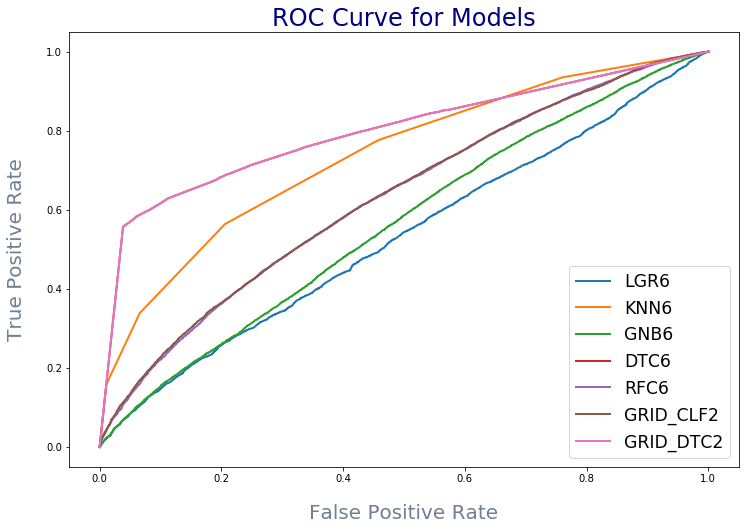

In [117]:
model_name = ['LGR6', 'KNN6', 'GNB6', 'DTC6','RFC6', 'GRID_CLF2', 'GRID_DTC2']
classifiers = [log_reg6, knn6, gnb6, dtc6, rfc6, grid_clf2, grid_dtc2]

plt.figure(figsize=(12,8))

for r in range(len(model_name)):
    false_pos, true_pos, thresholds = roc_curve(y_test, classifiers[r].predict_proba(X_test)[:,1], pos_label=1)
    AUC_score = roc_auc_score(y_test, classifiers[r].predict_proba(X_test)[:,1])
    print(f'AUC for {model_name[r]} model is {AUC_score}')
    plt.plot(false_pos, true_pos, linewidth=2, label=model_name[r])
    plt.title('ROC Curve for Models', fontsize='24', color = 'navy')
    plt.xlabel('False Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.ylabel('True Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.legend(loc="lower right", fontsize= 'xx-large')

### This run: 

- AUC for LGR6 model is 0.5292945907706789
- AUC for KNN6 model is 0.737273461488521
- AUC for GNB6 model is 0.5626419544935178
- AUC for DTC6 model is 0.797162707935465
- AUC for RFC6 model is 0.6256391416800857
- AUC for GRID_CLF2 model is 0.6276495993514912
- AUC for GRID_DTC2 model is 0.797162707935465

### Check to see if my model is overfit or underfit

In [118]:
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!

stacked = StackingClassifier(
    classifiers=classifiers, meta_classifier=LogisticRegression(), use_probas=False)

In [119]:
stacked.fit(X_train, y_train)

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='liblinear',
                                                   tol=0.0001, verbose=0,
                                                   warm_start=False),
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                        

In [120]:
AUC_score_stacked = roc_auc_score(y_train, stacked.predict_proba(X_train)[:,1])
AUC_score_stacked
# Last run: 0.8916430491441917
# This run: 0.8792894624734766

0.8944841720437352

In [121]:
AUC_score_stacked = roc_auc_score(y_test, stacked.predict_proba(X_test)[:,1])
AUC_score_stacked
# Last run: 0.7990725176802546
# This run: 0.7870982435780555

0.7909092938745229

## Ensembling

In [122]:
y = try_inspec_lic_pop['Results_Pass_Fail']
X = try_inspec_lic_pop.drop(columns = ['Results_Pass_Fail', 'aka'])

In [123]:
def quick_test2(rfc6, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    rfc6.fit(X_train, y_train)
    return rfc6.score(X_test, y_test)

def quick_test_afew_times2(rfc6, X, y, n=10):
    return np.mean([quick_test2(rfc6, X, y) for j in range(n)])

In [124]:
decisiontree3 = DecisionTreeClassifier(max_depth=4)
quick_test_afew_times2(decisiontree3, X, y)
# First Test: 0.7457216819422096
# This Test: 0.5619518076975437

0.558315019739785

In [125]:
# This is super slow
randomforest3 = RandomForestClassifier(n_estimators=10)
quick_test_afew_times2(randomforest3, X, y)
# First Test: 0.6891940110543623
# This test: 0.7618351193138724

0.7574184639919096

### Random Forest for Classification:

In [126]:
y = try_inspec_lic_pop['Results_Pass_Fail']
X = try_inspec_lic_pop.drop(columns = ['Results_Pass_Fail', 'aka'])

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [128]:
# Feature Scaling
stacked2 = StandardScaler()
X_train = stacked2.fit_transform(X_train)
X_test = stacked2.transform(X_test)

In [129]:
# Training the Algorithm (200 estimators)
classifier2 = RandomForestClassifier(n_estimators=200, random_state=0)
classifier2.fit(X_train, y_train)
y_pred = classifier2.predict(X_test)

In [130]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluating the Algorithm
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[21600  4187]
 [ 7775 17857]]
              precision    recall  f1-score   support

           0       0.74      0.84      0.78     25787
           1       0.81      0.70      0.75     25632

    accuracy                           0.77     51419
   macro avg       0.77      0.77      0.77     51419
weighted avg       0.77      0.77      0.77     51419

0.7673622590871079


The **accuracy** achieved by the random forest classifier with n_estimators=200 is 76.736%. 


In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
# stratify=y equal amounts from each of the targets; always try to set stratified = yes

In [132]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

# prints confusion matrix as a heatmap which is nicer to visaulize

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

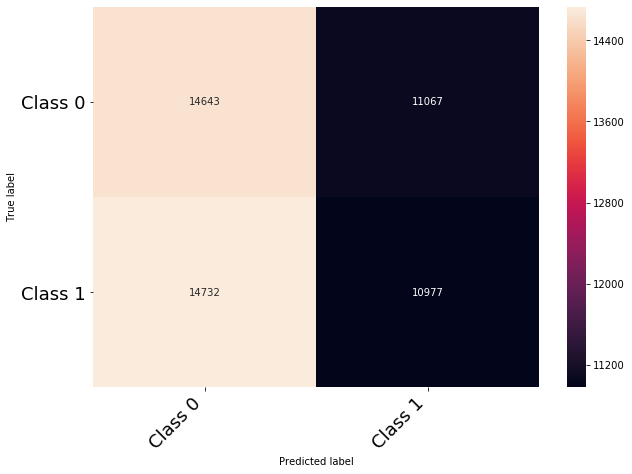

In [133]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])


### Cross Validation


In [134]:
clf3 = RandomForestClassifier(n_estimators=20) #Initialize with whatever parameters you want to

# 10-Fold Cross validation
print(np.mean(cross_val_score(clf3, X_train, y_train, cv=10)))

# First score: 0.686491697338057
# This score:0.7551030903208416

0.7572618265118309


### Using [GridSearchCV ](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)


In [135]:
grid_clf3 = GridSearchCV(clf3, param_grid, cv=10)
grid_clf3.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [136]:
grid_clf_predict3 = grid_clf3.predict(X_test)
grid_clf_accuracy3 = accuracy_score(y_test, grid_clf_predict3)
grid_clf_accuracy3
# With clf3 = 0.5867675372916626

0.5859118224780723

In [137]:
# Using best params from GridSearch results
# Print accuracy DTC
dtc7 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
dtc7.fit(X_train, y_train)
dtc_predict7 = dtc7.predict(X_test)
dtc_accuracy7 = accuracy_score(y_test, dtc_predict7)
dtc_accuracy7
# First run: 0.6758641786479046
# Second run: 0.6722239216885898
# Last run: 0.758318909352574
# This run: 0.7578716038818336

0.7578716038818336

In [138]:
# Using best params from GridSearch results
# Print accuracy RFC
rfc7 = RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False)
rfc7.fit(X_train, y_train)
rfc_predict7 = rfc7.predict(X_test)
rfc_accuracy7 = accuracy_score(y_test, rfc_predict7)
rfc_accuracy7
# First run: 0.7867849495258489
# Second run: 0.5812442871312161
# Last run: 0.5849005231529202
# This run: 0.7640366401524729

0.7613333592640853

In [139]:
clf3.fit(X_train, y_train)
clf_predict3 = clf3.predict(X_test)
clf_accuracy3 = accuracy_score(y_test, clf_predict3)
clf_accuracy3

0.763550438553842

In [140]:
grid_dtc2_predict = grid_dtc2.predict(X_test)
grid_dtc2_accuracy = accuracy_score(y_test, grid_dtc2_predict)
grid_dtc2_accuracy

0.8359944767498395

AUC for DTC6 model is 0.9047767363468568
AUC for RFC6 model is 0.6440760809139312
AUC for DTC7 model is 0.7965506497118613
AUC for RFC7 model is 0.833735865404011
AUC for CLF3 model is 0.8349092857634877
AUC for Grid_Clf3 model is 0.6322275233536758
AUC for Grid_DTC2 model is 0.9047767363468568
AUC for Classifier2 model is 0.524092109123265


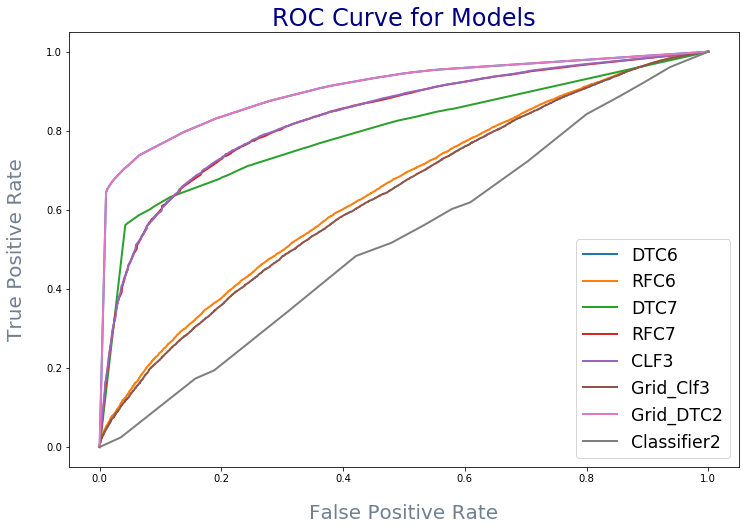

In [141]:
model_name = ['DTC6','RFC6','DTC7','RFC7','CLF3','Grid_Clf3','Grid_DTC2', 'Classifier2']
classifiers = [dtc6, rfc6, dtc7, rfc7, clf3, grid_clf3, grid_dtc2, classifier2]

plt.figure(figsize=(12,8))

for r in range(len(model_name)):
    false_pos, true_pos, thresholds = roc_curve(y_test, classifiers[r].predict_proba(X_test)[:,1], pos_label=1)
    AUC_score = roc_auc_score(y_test, classifiers[r].predict_proba(X_test)[:,1])
    print(f'AUC for {model_name[r]} model is {AUC_score}')
    plt.plot(false_pos, true_pos, linewidth=2, label=model_name[r])
    plt.title('ROC Curve for Models', fontsize='24', color = 'navy')
    plt.xlabel('False Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.ylabel('True Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.legend(loc="lower right", fontsize= 'xx-large')

In [142]:
from copy import deepcopy

In [143]:
Grid_DTC2_datatest = deepcopy(grid_dtc2)
CLF3_datatest = deepcopy(clf3)

In [144]:
Grid_DTC2_datatest.fit(X_train,y_train)
CLF3_datatest.fit(X_train,y_train)

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [145]:
type(CLF3_datatest)

sklearn.ensemble.forest.RandomForestClassifier

AUC for CLF3_datatest model is 0.8346088773038405
AUC for Grid_DTC2_datatest model is 0.7965506497118613


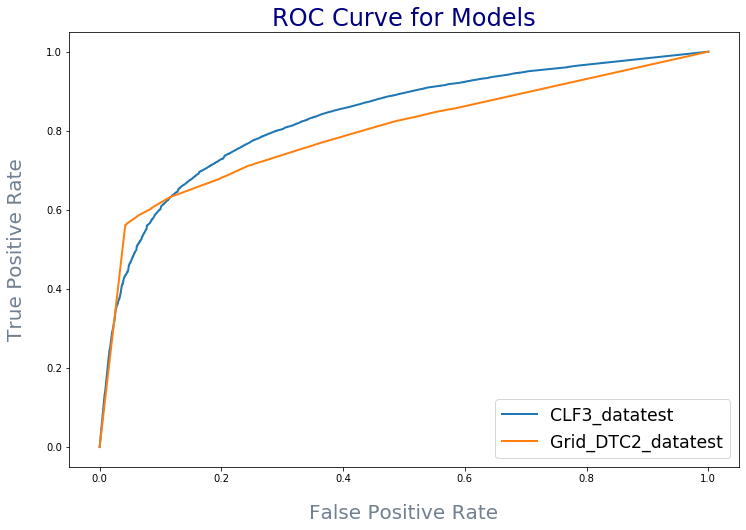

In [146]:
model_name = ['CLF3_datatest','Grid_DTC2_datatest']
classifiers = [CLF3_datatest, Grid_DTC2_datatest]

plt.figure(figsize=(12,8))

for r in range(len(model_name)):
    false_pos, true_pos, thresholds = roc_curve(y_test, classifiers[r].predict_proba(X_test)[:,1], pos_label=1)
    AUC_score = roc_auc_score(y_test, classifiers[r].predict_proba(X_test)[:,1])
    print(f'AUC for {model_name[r]} model is {AUC_score}')
    plt.plot(false_pos, true_pos, linewidth=2, label=model_name[r])
    plt.title('ROC Curve for Models', fontsize='24', color = 'navy')
    plt.xlabel('False Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.ylabel('True Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.legend(loc="lower right", fontsize= 'xx-large')

### AUC for CLF3_datatest is 0.8341088314551404; accuracy = 0.7635115424259515

In [147]:
# Print accuracy CLF3_datatest
CLF3_datatest_predict = CLF3_datatest.predict(X_test)
CLF3_datatest_accuracy1 = accuracy_score(y_test, CLF3_datatest_predict)
CLF3_datatest_accuracy1

0.7643478091755965

## Run Random Forest Classifier 'CLF3_datatest' against all data

In [148]:
y = zip_combined_upsampled['Results_Pass_Fail']
X = zip_combined_upsampled.drop(columns = ['Results_Pass_Fail','aka'])

In [149]:
CLF3_datatest.fit(X,y)
CLF3_datatest_predict = CLF3_datatest.predict(X)
CLF3_datatest_accuracy = accuracy_score(y, CLF3_datatest_predict)
CLF3_datatest_accuracy

0.8585964666619991

### Accuracy against entire dataset: 0.8586081355457537


### ROC Curve for CLF3_datatest

AUC for CLF3_datatest model is 0.9399037569140498


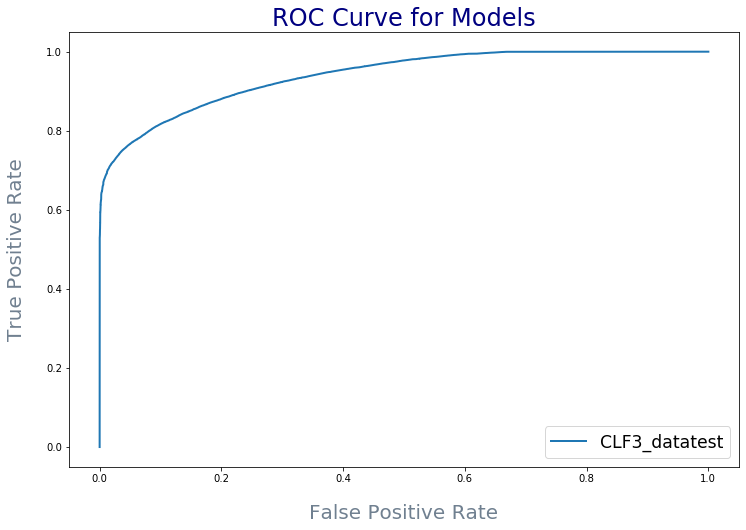

In [150]:
model_name = ['CLF3_datatest']
classifiers = [CLF3_datatest]

plt.figure(figsize=(12,8))

for r in range(len(model_name)):
    false_pos, true_pos, thresholds = roc_curve(y_test, classifiers[r].predict_proba(X_test)[:,1], pos_label=1)
    AUC_score = roc_auc_score(y_test, classifiers[r].predict_proba(X_test)[:,1])
    print(f'AUC for {model_name[r]} model is {AUC_score}')
    plt.plot(false_pos, true_pos, linewidth=2, label=model_name[r])
    plt.title('ROC Curve for Models', fontsize='24', color = 'navy')
    plt.xlabel('False Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.ylabel('True Positive Rate', fontsize='20', color = 'slategrey', labelpad = 20)
    plt.legend(loc="lower right", fontsize= 'xx-large')

### AUC for CLF3_datatest model is ~0.94


### CLF3_datatest.feature_importances_


In [151]:
CLF3_datatest_list = list(zip(CLF3_datatest.feature_importances_, X.columns))
sorted(CLF3_datatest_list, reverse=True)

[(0.2606457910413434, 'population'),
 (0.2585835556268421, 'income'),
 (0.042057124228733964, 'risk'),
 (0.023286548392699467, 'day_3'),
 (0.022189805352817123, 'day_1'),
 (0.02087795365291618, 'day_4'),
 (0.019729983693647802, 'day_2'),
 (0.018081625476305745, 'day_0'),
 (0.016739080859637902, 'month_5'),
 (0.01642343891973132, 'month_7'),
 (0.016216669786698487, 'month_4'),
 (0.016046864479330087, 'month_6'),
 (0.015928540301281748, 'month_8'),
 (0.015522439490465504, 'month_10'),
 (0.015490026731617246, 'inspection_type_canvass'),
 (0.015110988800511236, 'month_1'),
 (0.015028402511051822, 'inspection_type_License'),
 (0.014208913374933746, 'month_3'),
 (0.013935709138161972, 'month_11'),
 (0.013631263466401589, 'month_2'),
 (0.013390806671257121, 'month_9'),
 (0.013326207577316479, 'year_2018'),
 (0.012822198075843814, 'year_2015'),
 (0.012432494153767017, 'year_2012'),
 (0.012418868678119229, 'year_2017'),
 (0.011861504135944143, 'month_12'),
 (0.011705569334553016, 'year_2016'),


### Maybe just use all of my features?

In [152]:
CLF3_datatest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Set up a df like this:

Restaurant |X = Feats-> pop, inc.,risk,etc.|  y = Pass (1)/Fail(0)  | $\hat{y}$|$\hat{y}$.predict_proba|
-----------|-------------------------------|------------------------|----------|-----------------------|
Restaurant1|20000, 60000, 3, etc.          |       1   or 0         |  1 or 0  |       .75             |
Restaurant2|10000, 75000, 3, etc.          |       1   or 0         |  1 or 0  |       .85             |




## From here:
https://github.com/thisismetis/chi20_ds13/blob/master/curriculum/project-03/ensembling/Ensemble_Methods.ipynb

### Predict class for X

In [153]:
Pass_Fail = zip_combined_upsampled.Results_Pass_Fail
Pass_Fail.head()

0    1
1    1
2    1
3    1
4    1
Name: Results_Pass_Fail, dtype: uint8

In [154]:
Restaurant_names = zip_combined_upsampled['aka']
Restaurant_names.head()

0         STARBUCKS COFFEE
1      KELLY'S CAJUN GRILL
2               MONK'S PUB
3    GIORDANO'S ON JACKSON
4             Skadden Cafe
Name: aka, dtype: object

In [155]:
RF_predicts = list(zip(CLF3_datatest.predict(X), Restaurant_names))
RF_predicts

[(1, 'STARBUCKS COFFEE'),
 (1, "KELLY'S CAJUN GRILL"),
 (1, "MONK'S PUB"),
 (1, "GIORDANO'S ON JACKSON"),
 (0, 'Skadden Cafe'),
 (1, 'DUNKIN DONUTS/BASKIN ROBBINS'),
 (1, 'AJIDA'),
 (1, "GIORDANO'S ON JACKSON"),
 (1, 'THE WORKS OFF VAN BUREN'),
 (1, 'EUREST DINING SERVICES'),
 (1, '123 CAFE'),
 (0, 'BE LEAF'),
 (1, 'PIEROGI HEAVEN'),
 (1, 'SUBWAY'),
 (0, 'NOODLES & COMPANY'),
 (1, 'TOKYO LUNCH BOX & SAKE BAR'),
 (1, 'I DREAM OF FALAFEL'),
 (0, 'TACO FRESCO'),
 (0, "SPECIALTY'S CAFE BAKERY"),
 (1, 'PRET A MANAGER'),
 (1, 'TORTAZO WILLIS'),
 (1, 'EAT & DRINK'),
 (0, 'PANDA EXPRESS'),
 (1, 'SOUTH BRANCH'),
 (1, "BOAR'S HEAD CAFE"),
 (1, 'FRESHII'),
 (1, 'ARGO TEA'),
 (0, "MARCELLO'S MARKET & DELI"),
 (1, "O'VIE BAR & GRILL"),
 (1, 'NOODLES & COMPANY'),
 (1, "ROBINSON'S #1 RIB"),
 (0, '11 DINING'),
 (1, 'STARBUCKS COFFEE'),
 (1, 'Chipotle Mexican Grill'),
 (1, 'TORTAZO WILLIS'),
 (1, 'STARBUCKS COFFEE'),
 (1, 'HALSTED STREET DELI & BAGEL'),
 (1, 'JIMMY JOHNS'),
 (1, 'IDOF FRESH MEDITERRANE

### Predict class probabilities for X

In [156]:
RF_probas = list(zip(CLF3_datatest.predict_proba(X), Restaurant_names))
RF_probas

[(array([0.05, 0.95]), 'STARBUCKS COFFEE'),
 (array([0., 1.]), "KELLY'S CAJUN GRILL"),
 (array([0., 1.]), "MONK'S PUB"),
 (array([0.025, 0.975]), "GIORDANO'S ON JACKSON"),
 (array([0.50386905, 0.49613095]), 'Skadden Cafe'),
 (array([0., 1.]), 'DUNKIN DONUTS/BASKIN ROBBINS'),
 (array([0.25, 0.75]), 'AJIDA'),
 (array([0., 1.]), "GIORDANO'S ON JACKSON"),
 (array([0.1, 0.9]), 'THE WORKS OFF VAN BUREN'),
 (array([0., 1.]), 'EUREST DINING SERVICES'),
 (array([0., 1.]), '123 CAFE'),
 (array([0.78896645, 0.21103355]), 'BE LEAF'),
 (array([0., 1.]), 'PIEROGI HEAVEN'),
 (array([0.39631249, 0.60368751]), 'SUBWAY'),
 (array([0.65711484, 0.34288516]), 'NOODLES & COMPANY'),
 (array([0.05, 0.95]), 'TOKYO LUNCH BOX & SAKE BAR'),
 (array([0.1125, 0.8875]), 'I DREAM OF FALAFEL'),
 (array([0.57015471, 0.42984529]), 'TACO FRESCO'),
 (array([0.67474692, 0.32525308]), "SPECIALTY'S CAFE BAKERY"),
 (array([0.36076568, 0.63923432]), 'PRET A MANAGER'),
 (array([0., 1.]), 'TORTAZO WILLIS'),
 (array([0., 1.]), 'E

### Predict class predictions and probabilities for X

In [157]:
RF_predict_probas = list(zip(Restaurant_names, Pass_Fail, CLF3_datatest.predict(X), CLF3_datatest.predict_proba(X)))
RF_predict_probas

[('STARBUCKS COFFEE', 1, 1, array([0.05, 0.95])),
 ("KELLY'S CAJUN GRILL", 1, 1, array([0., 1.])),
 ("MONK'S PUB", 1, 1, array([0., 1.])),
 ("GIORDANO'S ON JACKSON", 1, 1, array([0.025, 0.975])),
 ('Skadden Cafe', 1, 0, array([0.50386905, 0.49613095])),
 ('DUNKIN DONUTS/BASKIN ROBBINS', 1, 1, array([0., 1.])),
 ('AJIDA', 1, 1, array([0.25, 0.75])),
 ("GIORDANO'S ON JACKSON", 1, 1, array([0., 1.])),
 ('THE WORKS OFF VAN BUREN', 1, 1, array([0.1, 0.9])),
 ('EUREST DINING SERVICES', 1, 1, array([0., 1.])),
 ('123 CAFE', 1, 1, array([0., 1.])),
 ('BE LEAF', 1, 0, array([0.78896645, 0.21103355])),
 ('PIEROGI HEAVEN', 1, 1, array([0., 1.])),
 ('SUBWAY', 1, 1, array([0.39631249, 0.60368751])),
 ('NOODLES & COMPANY', 1, 0, array([0.65711484, 0.34288516])),
 ('TOKYO LUNCH BOX & SAKE BAR', 1, 1, array([0.05, 0.95])),
 ('I DREAM OF FALAFEL', 1, 1, array([0.1125, 0.8875])),
 ('TACO FRESCO', 1, 0, array([0.57015471, 0.42984529])),
 ("SPECIALTY'S CAFE BAKERY", 1, 0, array([0.67474692, 0.32525308])),

In [158]:
Pred_probs_df = pd.DataFrame(RF_predict_probas, columns = ['RestaurantName', 'Results_Pass_Fail', 'Prediction', 'Class Probabilities'])
Pred_probs_df

,RestaurantName,Results_Pass_Fail,Prediction,Class Probabilities
0,STARBUCKS COFFEE,1,1,"[0.05, 0.95]"
1,KELLY'S CAJUN GRILL,1,1,"[0.0, 1.0]"
2,MONK'S PUB,1,1,"[0.0, 1.0]"
3,GIORDANO'S ON JACKSON,1,1,"[0.025, 0.975]"
4,Skadden Cafe,1,0,"[0.5038690476190476, 0.4961309523809523]"
...,...,...,...,...
171391,BIRRIERIA OCOTLAN,0,0,"[0.5425992063492063, 0.45740079365079367]"
171392,PROST,0,0,"[0.7657142857142858, 0.2342857142857143]"
171393,Benchwarmers Sports Bar and Grill,0,0,"[0.8568001443001443, 0.14319985569985566]"
171394,THE FLAT TOP GRILL,0,0,"[0.8080952380952379, 0.1919047619047619]"


In [159]:
Features_df = zip_combined_upsampled.drop(columns = ['Results_Pass_Fail'])
Features_df.head()

,aka,population,income,risk,day_1,day_3,day_2,day_4,day_0,month_6,month_3,month_7,month_2,month_8,month_11,month_4,month_5,month_10,year_2017,year_2012,month_1,year_2015,year_2016,year_2011,year_2019,year_2018,month_9,year_2010,month_12,year_2013,year_2014,inspection_type_License,inspection_type_canvass,inspection_type_Complaint_Other
0,STARBUCKS COFFEE,1682,100377.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,KELLY'S CAJUN GRILL,1682,100377.0,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,MONK'S PUB,1682,100377.0,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,GIORDANO'S ON JACKSON,1682,100377.0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Skadden Cafe,1682,100377.0,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [160]:
Features_df = Features_df.rename(columns={"aka": "RestaurantName"})
Features_df.head()

,RestaurantName,population,income,risk,day_1,day_3,day_2,day_4,day_0,month_6,month_3,month_7,month_2,month_8,month_11,month_4,month_5,month_10,year_2017,year_2012,month_1,year_2015,year_2016,year_2011,year_2019,year_2018,month_9,year_2010,month_12,year_2013,year_2014,inspection_type_License,inspection_type_canvass,inspection_type_Complaint_Other
0,STARBUCKS COFFEE,1682,100377.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,KELLY'S CAJUN GRILL,1682,100377.0,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,MONK'S PUB,1682,100377.0,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,GIORDANO'S ON JACKSON,1682,100377.0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Skadden Cafe,1682,100377.0,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [161]:
Pred_probs_df.head()

,RestaurantName,Results_Pass_Fail,Prediction,Class Probabilities
0,STARBUCKS COFFEE,1,1,"[0.05, 0.95]"
1,KELLY'S CAJUN GRILL,1,1,"[0.0, 1.0]"
2,MONK'S PUB,1,1,"[0.0, 1.0]"
3,GIORDANO'S ON JACKSON,1,1,"[0.025, 0.975]"
4,Skadden Cafe,1,0,"[0.5038690476190476, 0.4961309523809523]"


In [162]:
Features_df.shape

(171396, 34)

In [163]:
Pred_probs_df.shape

(171396, 4)

In [164]:
pd.to_pickle(Features_df, "./feat_dummy.pkl")

In [165]:
pd.to_pickle(Pred_probs_df, "./pred_dummy.pkl")

In [167]:
# unpickled_feat_df = pd.read_pickle("./feat_dummy.pkl")
# unpickled_feat_df

In [168]:
# unpickled_pred_df = pd.read_pickle("./pred_dummy.pkl")
# unpickled_pred_df

### Pickle CLF3_datatest


In [171]:
# import pickle
# pickle.dump(CLF3_datatest,open("my_pickled_CLF3_datatest_model_y.p", "wb"))